# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Quality-Control-on-the-hypoxia-response-and-the-hif-1-direct-target-predictions" data-toc-modified-id="Quality-Control-on-the-hypoxia-response-and-the-hif-1-direct-target-predictions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Quality Control on the hypoxia response and the hif-1 direct target predictions</a></div><div class="lev1 toc-item"><a href="#TEA-on-hypoxia-response" data-toc-modified-id="TEA-on-hypoxia-response-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TEA on hypoxia response</a></div>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan

# stats
from scipy import stats as sts

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)

import gvars


# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('paper', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize
import genpy

In [2]:
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')

In [3]:
# import the code <--> genotype mapping and other useful variables
genvar = gvars.genvars()

In [4]:
tf_df = pd.read_csv('../input/tf_list.csv')
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv', sep=',')

In [5]:
hypoxia_direct_targets = pd.read_csv('../output/hypoxia_targets_candidates.csv')

In [6]:
hypoxia_direct_targets.ens_gene.unique().shape

(124,)

In [7]:
hypoxia_response = pd.read_csv('../output/hypoxia_response.csv')

In [8]:
hypoxia_response.ens_gene.unique().shape

(260,)

In [9]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# # load all the beta values for each genotype:
# sleuth_loc = '../sleuth/'
# thomas.add_betas(sleuth_loc, 'betas.csv', combs)

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)
thomas.filter_data(0, 0.1)

Number of na genes: 232


In [10]:
frames = []
for key, df in thomas.beta.items():
    df['code'] = key
    df['genotype'] = genvar.fancy_mapping[key]
    frames += [df]

tidy = pd.concat(frames)

In [11]:
x = ['WBGene00012324',
     'WBGene00001178',
     'WBGene00003647',
     'WBGene00002248'
    ]

x_sort = {'WBGene00012324': 1,
          'WBGene00001178': 2,
          'WBGene00003647': 3,
          'WBGene00002248': 4
         }

plot_df = tidy[(tidy.ens_gene.isin(x)) & (tidy.code != 'g')].copy()
# Pick the hif-1 isoform that is present in all genotypes:
plot_df = plot_df[plot_df.target_id != 'F38A6.3d']
plot_df['order'] = plot_df.ens_gene.map(x_sort)
plot_df.sort_values('order', inplace=True)
plot_df.reset_index(inplace=True)  
plot_df = plot_df[['target_id', 'ens_gene', 'ext_gene','b', 'se_b', 'qval', 'genotype', 'order', 'code']]

In [12]:
def pathify(title, xlabel, ylabel, xticks=True, yticks=True, **kwargs):
    """
    A function to pathify the labels, titles and ticks in a plot.
    """
    labelsize = kwargs.pop('labelsize', 20)
    titlesize = kwargs.pop('titlesize', 25)
    
    # make the labels and title into paths
    effect = [path_effects.Normal()]
    plt.ylabel(ylabel,
               fontsize=labelsize).set_path_effects(effect)
    plt.xlabel(xlabel,
               fontsize=labelsize).set_path_effects(effect)
    plt.title(title,
              fontsize=titlesize).set_path_effects(effect)

    ax = plt.gca()
    # go through each xtick or ytick and make 
    # it a path if user specified to do so.
    if xticks == True:
        for i, label in enumerate(ax.get_xticklabels()):
            ax.get_xticklabels()[i].set_path_effects(effect)
    if yticks == True:
        for i, label in enumerate(ax.get_yticklabels()):
            ax.get_yticklabels()[i].set_path_effects(effect)

In [16]:
# a qPCR barplot
def qPCR_plot(df, plotting, colors, **kwargs):
    """
    A function to make prettified qPCR barplots. 
    
    Takes as entry a dataframe as output by qPCR_prep method
    
    Params:
    df -- df as output by qPCR_prep
    plotting -- a dictionary of plotting order for each gene;
                keys must be in dataframe column 'plotting_group'
    colors -- color to be used for each gene
    kwargs -- clustering - the name of a column within the dataframe,
              bars grouped within the same cluster are given the same color;
              plotting_group - a string that must be a column within the
              dataframe, bars belonging to the same plotting group are 
              plotted adjacent to each other;
              alpha (transparency, float);
              q (stat. sig. thresh, float);
              save (string to save as)
              rotation;
              title
    
    outputs:
    a Seaborn barchart
    """
    clustering = kwargs.pop('clustering', 'ext_gene')
    plotting_group = kwargs.pop('plotting_group', 'genotype')
    alpha = kwargs.pop('alpha', 0.7)
    q = kwargs.pop('q', 0.1)
    save = kwargs.pop('save', '')
    rotation = kwargs.pop('rotation', 45)
    title = kwargs.pop('title', r'\emph{In Silico} qPCR')
    
    index = np.linspace(0, df[plotting_group].unique().shape[0]-1,
                        df[plotting_group].unique().shape[0])
    
    # error bars
    error_config = {'ecolor': '0.2'}

    # groupby gene name if it exists:
    grouped = df.groupby(clustering)
    
    bar_width = 1/(len(grouped)+1)
    
    # go through each gene
    for name, group in grouped:
        # figure out where each bar goes:
        if name not in plotting.keys():
            print(name, 'not in plotting.keys()')
            where = max(plotting.keys(),
                        key=lambda k: plotting[k])
            val = plotting[where]
            plotting[name] = val + 1
        
        add = plotting[name]*bar_width
        # figure out what color to give:
        if name in colors.keys():
            # add the bar:
            barlist = plt.bar(index + add + bar_width/2, group.b.values,
                              bar_width, alpha=alpha,
                              yerr=group.se_b.values,
                              error_kw=error_config, label=name,
                              color=colors[name])
        else:
            # add the bar but don't specify color
            barlist = plt.bar(index + add, group.b.values,
                              bar_width, alpha=alpha,
                              yerr=group.se_b.values,
                              error_kw=error_config, label=name)

        # significance threshold:
        sig = group.qval < q
        k = group[sig].order - 1

        # plot stars on top of stat. sig. results
        plt.plot(k + add + bar_width/2,
                 group[sig].b.values + group[sig].se_b.values + 0.20,
                 r'*', color='k')
    
    # shade in every other bar group for clarity:
    grouped2 = df.groupby(plotting_group)
    k = 0
    col = '#CFCFCF'

    ymin, ymax = plt.gca().get_ylim()
    for name, group in grouped2:
        if k % 2 == 0:
            xmin = k - bar_width*0.5
            xmax = k + bar_width*(len(grouped) + 0.5)
            
            plt.fill_between([xmin, xmax], ymin, color=col)
            plt.fill_between([xmin, xmax], ymax, color=col)
        k += 1
    
    # fix the xlims and tick params etc...
    if (k - 1) % 2 == 0:
        plt.xlim(0, xmax)
    else:
        plt.xlim(0, plt.gca().get_xlim()[1] - 3/2*bar_width)

    plt.tick_params(axis='y',
                    which='major', labelsize=18)
    
    fancy_names = []
    fancy_names = []
    for label in df[plotting_group].unique():
        genename = df[df[plotting_group] == label ].ens_gene.values[0]
        n_isoforms = df[df.ens_gene == genename].shape[0]/len(df.code.unique())
        if n_isoforms == 1:
            name = df[df[plotting_group] == label].ext_gene.values[0]
        else:
            name = label
        if r'\emph' not in name:
            fancy_names += [r'\emph{' + name + r'}']
        else:
            fancy_names += name

    plt.xticks(index + bar_width*len(df[clustering].unique())/2,
               fancy_names, rotation=rotation, fontsize=20)

    pathify(title, '',
            r'Regression Coefficient, $\beta$', )

    plt.legend(loc=(1.02, 0.5),fontsize=15)
    
    plt.ylim(ymin, ymax)

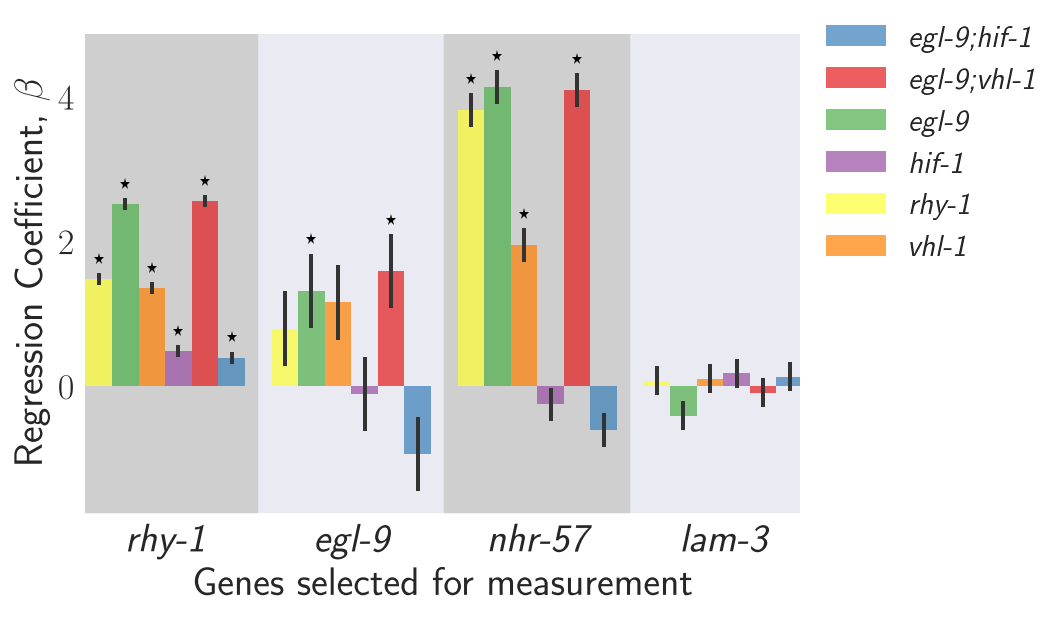

In [18]:
qPCR_plot(plot_df, genvar.plot_order, genvar.plot_color, clustering='genotype', plotting_group='ext_gene',
          title='', rotation=0)
plt.xlabel(r'Genes selected for measurement')
save = '../output/hif1_qualitycontrol.pdf'
plt.savefig(save, bbox_inches='tight')

# Quality Control on the hypoxia response and the hif-1 direct target predictions

In [19]:
def test_significance(df, gold=hypoxia_gold):
    ind = df.ens_gene.isin(hypoxia_gold.WBIDS)
    found = df[ind].ens_gene.unique()
    sig = len(df)  # number of genes that we picked
    ntotal = len(thomas.beta['a'])  # total genes measured
    pval = sts.hypergeom.sf(len(found),
                            ntotal,
                            len(hypoxia_gold), sig)    

    if pval < 10**-3:
        print('This result is statistically significant' +\
              'with a p-value of {0:.2g} using a hypergeometric test.'.format(pval) +\
              'You found {0} gold standard genes!'.format(len(found)))
    else:
        print(pval)

In [20]:
test_significance(hypoxia_response)

This result is statistically significantwith a p-value of 2.7e-06 using a hypergeometric test.You found 5 gold standard genes!


In [21]:
test_significance(hypoxia_direct_targets)

This result is statistically significantwith a p-value of 3.8e-08 using a hypergeometric test.You found 5 gold standard genes!


# TEA on hypoxia response

In [ ]:
_ = tea.enrichment_analysis(hypoxia_response.ens_gene.unique(), go_df, show=False)
ax = tea.plot_enrichment_results(_, analysis='go')
plt.savefig('../output/hypoxia_response_gea.svg')